Rozmiar danych X: (30, 20)
Rozmiar celów t: (30,)
Gradient parametru 0 jest poprawny.
Gradient parametru 1 jest poprawny.

Finalne wagi: wx = 0.0974, wRec = 0.9220
Wskazówka: Dla średniej z 20 kroków, idealne wagi to wx=0.05 (czyli 1/20) i wRec=1.0

--- TEST MODELU ---
Sekwencja testowa: [[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   0.33 0.33 0.33 0.33
  0.33 0.33 0.33 0.33 0.33 0.33]]
Oczekiwana średnia: 0.6650
Wynik modelu: 0.5374


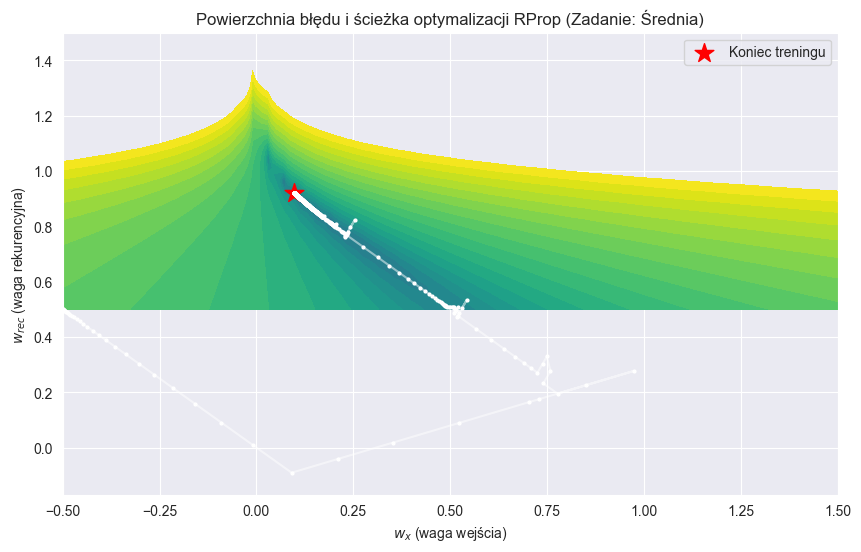

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import seaborn as sns

# Ustawienia stylu i powtarzalności
sns.set_style('darkgrid')
np.random.seed(seed=1)


#1. Tworzenie zbioru danych
nb_of_samples = 30
sequence_len = 20
# Losowanie wartości ze zbioru {0.33, 0.66, 1.0}
X = np.random.choice([0.33, 0.66, 1.0], size=(nb_of_samples, sequence_len))

t = np.mean(X, axis=1)

print(f"Rozmiar danych X: {X.shape}")  # (30, 20)
print(f"Rozmiar celów t: {t.shape}")   # (30,)


#2. Definicja modelu RNN (Forward Pass)

def update_state(xk, sk, wx, wRec):
    """Obliczenie stanu k na podstawie poprzedniego stanu i wejścia."""
    return xk * wx + sk * wRec

def forward_states(X, wx, wRec):
    """Przejście w przód przez całą sekwencję."""
    S = np.zeros((X.shape[0], X.shape[1] + 1))
    for k in range(0, X.shape[1]):
        S[:, k+1] = update_state(X[:, k], S[:, k], wx, wRec)
    return S

def loss(y, t):
    """Błąd średniokwadratowy (MSE)."""
    return np.mean((t - y)**2)

# 3. Propagacja wsteczna

def output_gradient(y, t):
    """Pochodna funkcji błędu względem wyjścia."""
    return 2. * (y - t)

def backward_gradient(X, S, grad_out, wRec):
    """Algorytm BPTT."""
    grad_over_time = np.zeros((X.shape[0], X.shape[1] + 1))
    grad_over_time[:, -1] = grad_out
    
    wx_grad = 0
    wRec_grad = 0
    
    for k in range(X.shape[1], 0, -1):
        wx_grad += np.sum(np.mean(grad_over_time[:, k:k+1] * X[:, k-1:k], axis=0))
        wRec_grad += np.sum(np.mean(grad_over_time[:, k:k+1] * S[:, k-1:k], axis=0))
        # Propagacja błędu do poprzedniego kroku czasowego
        grad_over_time[:, k-1] = grad_over_time[:, k] * wRec
        
    return (wx_grad, wRec_grad), grad_over_time


# 4. Sprawdzanie poprawności gradientów

params = [0.1, 0.1]  # Początkowe wx, wRec
eps = 1e-7
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:, -1], t)
backprop_grads, _ = backward_gradient(X, S, grad_out, params[1])

for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:, -1], t)
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:, -1], t)
    params[p_idx] += eps
    grad_num = (plus_loss - min_loss) / (2 * eps)
    if not np.isclose(grad_num, grad_backprop):
        print(f"BŁĄD GRADIENTU dla parametru {p_idx}: num={grad_num}, backprop={grad_backprop}")
    else:
        print(f"Gradient parametru {p_idx} jest poprawny.")


# 5. Optymalizacja RProp

def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:, -1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)
    
    for i, _ in enumerate(W):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

# Hiperparametry treningu
eta_p = 1.2
eta_n = 0.5
W = [-0.5, 0.5]  # Wagi początkowe [wx, wRec]
W_delta = [0.001, 0.001]
W_sign = [0, 0]

ls_of_ws = [(W[0], W[1])]

# Pętla treningowa (500 iteracji)
for i in range(500):
    W_delta, W_sign = update_rprop(X, t, W, W_sign, W_delta, eta_p, eta_n)
    for i in range(len(W)):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))

print(f"\nFinalne wagi: wx = {W[0]:.4f}, wRec = {W[1]:.4f}")
print("Wskazówka: Dla średniej z 20 kroków, idealne wagi to wx=0.05 (czyli 1/20) i wRec=1.0")


# 6. Testowanie modelu

# Test na nowej, ręcznie stworzonej sekwencji 20-elementowej
test_inpt = np.array([[1.0]*10 + [0.33]*10]) # 10 jedynek i 10 razy 0.33
test_outpt = forward_states(test_inpt, W[0], W[1])[:, -1]
real_mean = np.mean(test_inpt)

print(f"\n--- TEST MODELU ---")
print(f"Sekwencja testowa: {test_inpt}")
print(f"Oczekiwana średnia: {real_mean:.4f}")
print(f"Wynik modelu: {test_outpt[0]:.4f}")


# 7. Wizualizacja powierzchni błędu

def get_loss_surface(nb_of_ws, loss_func):
    w1 = np.linspace(-0.5, 1.5, num=nb_of_ws)
    w2 = np.linspace(0.5, 1.5, num=nb_of_ws)
    ws1, ws2 = np.meshgrid(w1, w2)
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i,j] = loss_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, loss_ws

ws1, ws2, loss_surface = get_loss_surface(50, lambda w1, w2: loss(forward_states(X, w1, w2)[:, -1], t))

plt.figure(figsize=(10, 6))
plt.contourf(ws1, ws2, loss_surface + 1e-5, levels=np.logspace(-5, 2, 30), cmap=cm.viridis, norm=LogNorm())
ws_array = np.array(ls_of_ws)
plt.plot(ws_array[:, 0], ws_array[:, 1], 'w-', alpha=0.5)
plt.plot(ws_array[:, 0], ws_array[:, 1], 'wo', markersize=2)
plt.scatter(W[0], W[1], color='red', marker='*', s=200, label='Koniec treningu')
plt.xlabel('$w_x$ (waga wejścia)')
plt.ylabel('$w_{rec}$ (waga rekurencyjna)')
plt.title('Powierzchnia błędu i ścieżka optymalizacji RProp (Zadanie: Średnia)')
plt.legend()
plt.show()